# Task 1 Acquire the data

Download and split  the data

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))   # flatten
])

no_norm_transform = transforms.Compose([
    transforms.ToTensor(),                   # keep pixel values in [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True,
transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True,transform=train_transform)

train_dataset_no_norm = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=False,
    transform=no_norm_transform
)

test_dataset_no_norm = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=False,
    transform=no_norm_transform
)
train_size = int(0.83 * len(train_dataset))  # ~50,000
val_size = len(train_dataset) - train_size   # ~10,000
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_subset_no_norm, val_subset_no_norm = random_split(
    train_dataset_no_norm,
    [train_size, val_size]
)

batch_size = 64
train_loader_no_norm = DataLoader(train_subset_no_norm, batch_size=batch_size, shuffle=True)
val_loader_no_norm   = DataLoader(val_subset_no_norm, batch_size=batch_size, shuffle=False)
test_loader_no_norm  = DataLoader(test_dataset_no_norm, batch_size=batch_size, shuffle=False)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


images, labels = next(iter(train_loader))
print("Flattened image shape:", images.shape)
print("Label shape:", labels.shape)


Flattened image shape: torch.Size([64, 784])
Label shape: torch.Size([64])


Training set class distribution: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Test set class distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


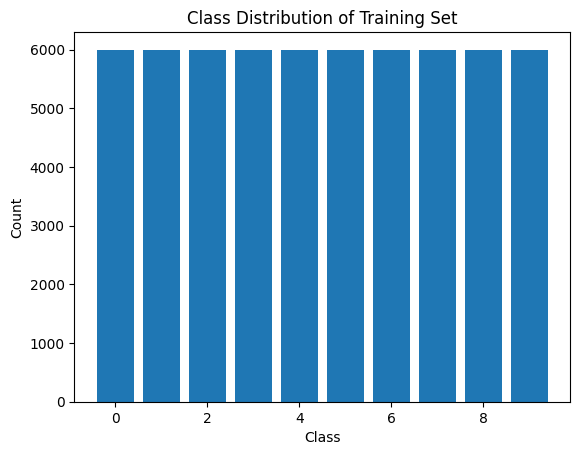

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_class_distribution(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    hist = np.bincount(labels, minlength=10)
    return hist

# distribution for normalized dataset
dist_train = compute_class_distribution(train_dataset)
dist_test = compute_class_distribution(test_dataset)

print("Training set class distribution:", dist_train)
print("Test set class distribution:", dist_test)

plt.bar(range(10), dist_train)
plt.title("Class Distribution of Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

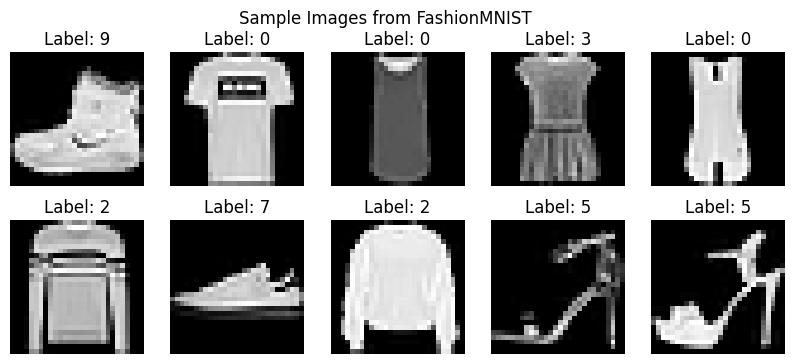

In [ ]:
import matplotlib.pyplot as plt

# Load raw dataset WITHOUT flatten/normalize
raw_dataset = datasets.FashionMNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    img, label = raw_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.suptitle("Sample Images from FashionMNIST")
plt.show()

In [ ]:
img, label = raw_dataset[0]
print("Shape:", img.shape)
print("Min pixel:", img.min().item())
print("Max pixel:", img.max().item())
print("Label:", label)

Shape: torch.Size([1, 28, 28])
Min pixel: 0.0
Max pixel: 1.0
Label: 9


# Task 2 Implement a MLP

In [ ]:
# ====== mlp_numpy.py ======
import numpy as np
from typing import List, Tuple, Callable, Dict

# -------- utils --------
def one_hot(y: np.ndarray, num_classes: int) -> np.ndarray:
    oh = np.zeros((y.size, num_classes), dtype=np.float32)
    oh[np.arange(y.size), y.astype(int)] = 1.0
    return oh

def he_init(fan_in, fan_out):
    # for ReLU
    return np.random.randn(fan_in, fan_out).astype(np.float32) * np.sqrt(2.0 / fan_in)

def xavier_init(fan_in, fan_out):
    # for tanh/sigmoid
    return np.random.randn(fan_in, fan_out).astype(np.float32) * np.sqrt(1.0 / fan_in)

# -------- activations --------
class Activation:
    def __init__(self, name: str):
        name = name.lower()
        if name == "relu":
            self.f = lambda z: np.maximum(0, z)
            self.df = lambda z: (z > 0).astype(np.float32)
            self.init = he_init
        elif name == "tanh":
            self.f = lambda z: np.tanh(z)
            self.df = lambda z: 1.0 - np.tanh(z) ** 2
            self.init = xavier_init
        elif name == "sigmoid":
            self.f = lambda z: 1.0 / (1.0 + np.exp(-z))
            def d_sigmoid(z):
                s = 1.0 / (1.0 + np.exp(-z))
                return s * (1 - s)
            self.df = d_sigmoid
            self.init = xavier_init
        elif name == "leakyrelu":
            self.f = lambda z: np.where(z > 0, z, 0.01 * z)
            self.df = lambda z: np.where(z > 0, 1.0, 0.01).astype(np.float32)
            self.init = he_init   # still He init
        else:
            raise ValueError("Unsupported activation: " + name)

# -------- MLP (from scratch with NumPy) --------
class MLP:
    """
    MLP implemented from scratch (NumPy only).
    - L hidden layers with chosen activation (e.g., ReLU)
    - Output layer uses softmax; loss = mean cross-entropy
    - Optimizer: vanilla SGD (mini-batch)
    - Supports optional L1 and L2 regularization
    """
    def __init__(self, input_dim: int, hidden_layers: List[int], num_classes: int,
                 activation: str = "relu", seed: int = 42):
        np.random.seed(seed)
        self.act = Activation(activation)
        self.layers = []
        layer_dims = [input_dim] + hidden_layers + [num_classes]

        # parameters: list of dicts {"W": (d_in,d_out), "b": (1,d_out)}
        for i in range(len(layer_dims) - 1):
            d_in, d_out = layer_dims[i], layer_dims[i + 1]
            # hidden layers use act-specific init; last layer use xavier
            if i < len(layer_dims) - 2:
                W = self.act.init(d_in, d_out)
            else:
                W = xavier_init(d_in, d_out)
            b = np.zeros((1, d_out), dtype=np.float32)
            self.layers.append({"W": W, "b": b})


    # ----- forward -----
    def _forward(self, X: np.ndarray) -> Tuple[list, list]:
        A = X
        Zs, As = [], [X]
        for i, layer in enumerate(self.layers):
            Z = A @ layer["W"] + layer["b"]      # (N, d_out)
            Zs.append(Z)

            if i < len(self.layers) - 1:
                A = self.act.f(Z)               # hidden activation
            else:
                A = self._softmax(Z)            # output softmax

            As.append(A)

        return Zs, As


    @staticmethod
    def _softmax(Z: np.ndarray) -> np.ndarray:
        Z_shift = Z - np.max(Z, axis=1, keepdims=True)
        exp = np.exp(Z_shift)
        return exp / np.sum(exp, axis=1, keepdims=True)


    @staticmethod
    def _cross_entropy(probs: np.ndarray, y_onehot: np.ndarray) -> float:
        eps = 1e-12
        return -np.mean(np.sum(y_onehot * np.log(probs + eps), axis=1))


    # ----- backward -----
    def _backward(self, Zs: list, As: list, y_onehot: np.ndarray) -> List[Dict[str, np.ndarray]]:
        grads = [None] * len(self.layers)
        N = y_onehot.shape[0]

        # last layer grad
        dZ = As[-1] - y_onehot  # (N, C)

        for i in reversed(range(len(self.layers))):
            A_prev = As[i]

            grads[i] = {
                "dW": (A_prev.T @ dZ) / N,
                "db": np.mean(dZ, axis=0, keepdims=True)
            }

            if i > 0:
                dA_prev = dZ @ self.layers[i]["W"].T
                dZ = dA_prev * self.act.df(Zs[i - 1])

        return grads


    # ----- SGD step (WITH L1/L2) -----
    def _step(self, grads: List[Dict[str, np.ndarray]], lr: float,
              l1_lambda: float, l2_lambda: float):

        for i, g in enumerate(grads):

            # ----- L2: W += lambda * W -----
            if l2_lambda > 0:
                g["dW"] += l2_lambda * self.layers[i]["W"]

            # ----- L1: W += lambda * sign(W) -----
            if l1_lambda > 0:
                g["dW"] += l1_lambda * np.sign(self.layers[i]["W"])

            # update
            self.layers[i]["W"] -= lr * g["dW"]
            self.layers[i]["b"] -= lr * g["db"]


    # ----- public API -----
    def fit(self, X: np.ndarray, y: np.ndarray,
            lr: float = 0.1, epochs: int = 5, batch_size: int = 64,
            l1_lambda: float = 0.0, l2_lambda: float = 0.0,
            verbose: bool = True):

        num_classes = self.layers[-1]["b"].shape[1]
        y_onehot_all = one_hot(y, num_classes)

        N = X.shape[0]
        indices = np.arange(N)

        for ep in range(1, epochs + 1):

            np.random.shuffle(indices)
            Xs = X[indices]
            ys = y_onehot_all[indices]

            for start in range(0, N, batch_size):
                end = min(start + batch_size, N)

                Xb = Xs[start:end]
                yb = ys[start:end]

                Zs, As = self._forward(Xb)
                grads = self._backward(Zs, As, yb)

                self._step(grads, lr, l1_lambda, l2_lambda)

            if verbose:
                _, As_full = self._forward(X)
                loss = self._cross_entropy(As_full[-1], y_onehot_all)
                preds = np.argmax(As_full[-1], axis=1)
                acc = (preds == y).mean()
                print(f"Epoch {ep:02d}: loss={loss:.4f}  acc={acc*100:.2f}%")

    def predict(self, X: np.ndarray) -> np.ndarray:
        _, As = self._forward(X)
        return np.argmax(As[-1], axis=1)

    @staticmethod
    def evaluate_acc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return float((y_true == y_pred).mean())

# Task3


##3.1

In [ ]:
model1 = MLP(
    input_dim=784,
    hidden_layers=[],   # no hidden layer
    num_classes=10,
    activation="relu"
)
model2 = MLP(
    input_dim=784,
    hidden_layers=[256],
    num_classes=10,
    activation="relu"
)
model3 = MLP(
    input_dim=784,
    hidden_layers=[256, 256],
    num_classes=10,
    activation="relu"
)

In [ ]:
def tensor_to_numpy(loader):
    xs, ys = [], []
    for xb, yb in loader:
        xs.append(xb.numpy())
        ys.append(yb.numpy())
    X = np.concatenate(xs, axis=0).astype(np.float32)
    y = np.concatenate(ys, axis=0).astype(np.int64)
    return X, y

X_train, y_train = tensor_to_numpy(train_loader)
X_val,   y_val   = tensor_to_numpy(val_loader)
X_test,  y_test  = tensor_to_numpy(test_loader)


In [ ]:
lrs_mlp = [0.01, 0.05, 0.1]
results_mlp = []

for lr in lrs_mlp:
    print(f"\n=== MLP (2 hidden layers, ReLU), lr={lr} ===")
    model = MLP(input_dim=784, hidden_layers=[256,256], num_classes=10, activation="relu")
    model.fit(X_train, y_train, lr=lr, epochs=2, batch_size=64, verbose=False)

    y_val_pred = model.predict(X_val)
    acc_val = MLP.evaluate_acc(y_val, y_val_pred)
    print(f"Val acc = {acc_val*100:.2f}%")

    results_mlp.append((lr, acc_val))



=== MLP (2 hidden layers, ReLU), lr=0.01 ===
Val acc = 84.02%

=== MLP (2 hidden layers, ReLU), lr=0.05 ===
Val acc = 85.75%

=== MLP (2 hidden layers, ReLU), lr=0.1 ===
Val acc = 86.23%


In [ ]:
batch_sizes = [32, 64, 128, 256, 512]
results_bs = []

for bs in batch_sizes:
    print(f"\n=== MLP (1 hidden layers, ReLU), batch_size={bs} ===")

    model = MLP(input_dim=784, hidden_layers=[256], num_classes=10, activation="relu")


    model.fit(X_train, y_train, lr=0.1, epochs=2, batch_size=bs, verbose=False)

    y_val_pred = model.predict(X_val)
    acc_val = MLP.evaluate_acc(y_val, y_val_pred)
    print(f"Val acc = {acc_val*100:.2f}%")

    results_bs.append((bs, acc_val))



=== MLP (1 hidden layers, ReLU), batch_size=32 ===
Val acc = 85.77%

=== MLP (1 hidden layers, ReLU), batch_size=64 ===
Val acc = 85.43%

=== MLP (1 hidden layers, ReLU), batch_size=128 ===
Val acc = 83.65%

=== MLP (1 hidden layers, ReLU), batch_size=256 ===
Val acc = 83.72%

=== MLP (1 hidden layers, ReLU), batch_size=512 ===
Val acc = 82.32%


In [ ]:
def train_with_tracking(model, X_train, y_train, X_test, y_test,
                        lr=0.1, epochs=10, batch_size=256,
                        l1_lambda=0.0, l2_lambda=0.0):

    N = X_train.shape[0]
    train_acc_list = []
    test_acc_list = []

    for ep in range(epochs):
        # Shuffle each epoch
        idx = np.random.permutation(N)
        X_train_shuffled = X_train[idx]
        y_train_shuffled = y_train[idx]

        # Mini-batch SGD
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            Xb = X_train_shuffled[start:end]
            yb = y_train_shuffled[start:end]

            Zs, As = model._forward(Xb)
            grads = model._backward(Zs, As, one_hot(yb, 10))
            model._step(grads, lr, l1_lambda, l2_lambda)

        # --- compute training accuracy ---
        y_train_pred = model.predict(X_train)
        train_acc = MLP.evaluate_acc(y_train, y_train_pred)
        train_acc_list.append(train_acc)

        # --- compute testing accuracy ---
        y_test_pred = model.predict(X_test)
        test_acc = MLP.evaluate_acc(y_test, y_test_pred)
        test_acc_list.append(test_acc)

        print(f"Epoch {ep+1}/{epochs}  Train Acc={train_acc*100:.2f}%  Test Acc={test_acc*100:.2f}%")

    return train_acc_list, test_acc_list


In [ ]:
print("Training model1...")
train_accs_model1, test_accs_model1 = train_with_tracking(
    model1, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256
)

print("\nTraining model2...")
train_accs_model2, test_accs_model2 = train_with_tracking(
    model2, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256
)

print("\nTraining model3...")
train_accs_model3, test_accs_model3 = train_with_tracking(
    model3, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256
)

acc_model1 = MLP.evaluate_acc(y_test, model1.predict(X_test))
acc_model2 = MLP.evaluate_acc(y_test, model2.predict(X_test))
acc_model3 = MLP.evaluate_acc(y_test, model3.predict(X_test))


Training model1...
Epoch 1/10  Train Acc=81.58%  Test Acc=80.08%
Epoch 2/10  Train Acc=84.08%  Test Acc=82.77%
Epoch 3/10  Train Acc=83.87%  Test Acc=82.39%
Epoch 4/10  Train Acc=84.39%  Test Acc=82.98%
Epoch 5/10  Train Acc=84.13%  Test Acc=82.61%
Epoch 6/10  Train Acc=84.67%  Test Acc=82.90%
Epoch 7/10  Train Acc=83.40%  Test Acc=81.05%
Epoch 8/10  Train Acc=84.45%  Test Acc=82.87%
Epoch 9/10  Train Acc=85.38%  Test Acc=83.31%
Epoch 10/10  Train Acc=85.55%  Test Acc=83.54%

Training model2...
Epoch 1/10  Train Acc=83.11%  Test Acc=81.74%
Epoch 2/10  Train Acc=81.08%  Test Acc=79.27%
Epoch 3/10  Train Acc=85.17%  Test Acc=83.48%
Epoch 4/10  Train Acc=87.08%  Test Acc=84.97%
Epoch 5/10  Train Acc=85.52%  Test Acc=83.36%
Epoch 6/10  Train Acc=86.94%  Test Acc=84.72%
Epoch 7/10  Train Acc=88.18%  Test Acc=85.92%
Epoch 8/10  Train Acc=88.35%  Test Acc=85.93%
Epoch 9/10  Train Acc=87.71%  Test Acc=85.19%
Epoch 10/10  Train Acc=89.28%  Test Acc=86.71%

Training model3...
Epoch 1/10  Train A

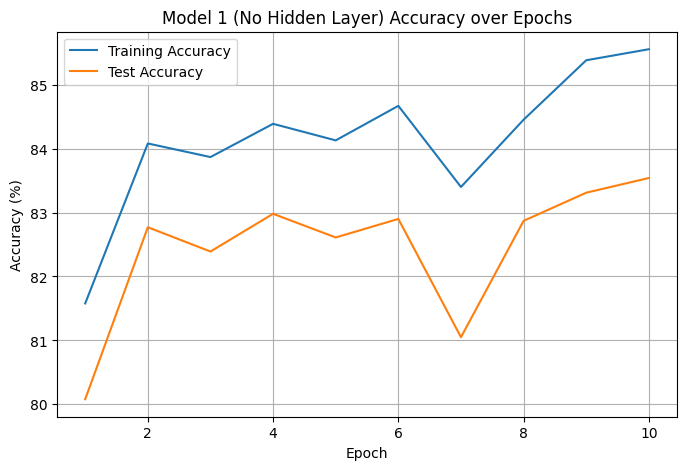

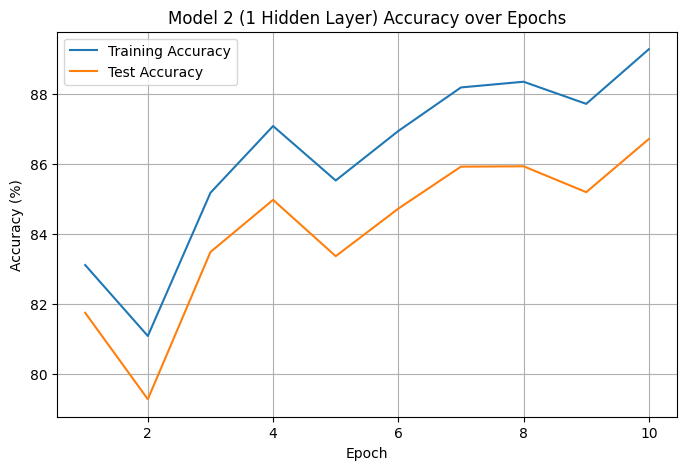

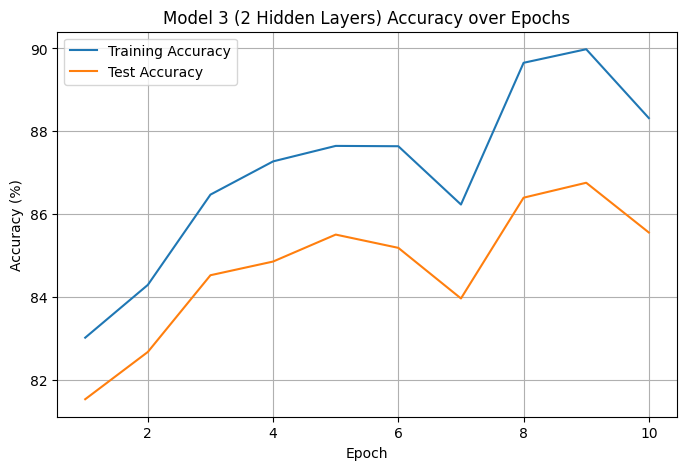

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(train_accs, test_accs, title):
    epochs = range(1, len(train_accs) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, [a * 100 for a in train_accs], label='Training Accuracy')
    plt.plot(epochs, [a * 100 for a in test_accs], label='Test Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(train_accs_model1, test_accs_model1, 'Model 1 (No Hidden Layer) Accuracy over Epochs')
plot_accuracies(train_accs_model2, test_accs_model2, 'Model 2 (1 Hidden Layer) Accuracy over Epochs')
plot_accuracies(train_accs_model3, test_accs_model3, 'Model 3 (2 Hidden Layers) Accuracy over Epochs')


##3.2

In [ ]:
model4 = MLP(
    input_dim=784,
    hidden_layers=[256, 256],
    num_classes=10,
    activation="tanh"
)
model5 = MLP(
    input_dim=784,
    hidden_layers=[256, 256],
    num_classes=10,
    activation="leakyrelu"
)
print("Training model4 (tanh)...")
train_accs_model4, test_accs_model4 = train_with_tracking(
    model4, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256
)

print("Training model5 (leakyrelu)...")
train_accs_model5, test_accs_model5 = train_with_tracking(
    model5, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256
)

acc_model4 = test_accs_model4[-1]
acc_model5 = test_accs_model5[-1]


Training model4 (tanh)...
Epoch 1/10  Train Acc=76.95%  Test Acc=75.72%
Epoch 2/10  Train Acc=84.71%  Test Acc=83.13%
Epoch 3/10  Train Acc=84.87%  Test Acc=83.34%
Epoch 4/10  Train Acc=86.42%  Test Acc=84.80%
Epoch 5/10  Train Acc=85.62%  Test Acc=83.87%
Epoch 6/10  Train Acc=86.69%  Test Acc=84.54%
Epoch 7/10  Train Acc=85.74%  Test Acc=84.02%
Epoch 8/10  Train Acc=85.64%  Test Acc=84.08%
Epoch 9/10  Train Acc=89.03%  Test Acc=86.50%
Epoch 10/10  Train Acc=84.57%  Test Acc=82.28%
Training model5 (leakyrelu)...
Epoch 1/10  Train Acc=80.69%  Test Acc=79.12%
Epoch 2/10  Train Acc=84.49%  Test Acc=82.83%
Epoch 3/10  Train Acc=83.57%  Test Acc=81.92%
Epoch 4/10  Train Acc=87.71%  Test Acc=85.81%
Epoch 5/10  Train Acc=87.36%  Test Acc=85.33%
Epoch 6/10  Train Acc=88.16%  Test Acc=85.50%
Epoch 7/10  Train Acc=88.41%  Test Acc=85.82%
Epoch 8/10  Train Acc=89.49%  Test Acc=86.50%
Epoch 9/10  Train Acc=87.15%  Test Acc=84.58%
Epoch 10/10  Train Acc=87.28%  Test Acc=84.65%


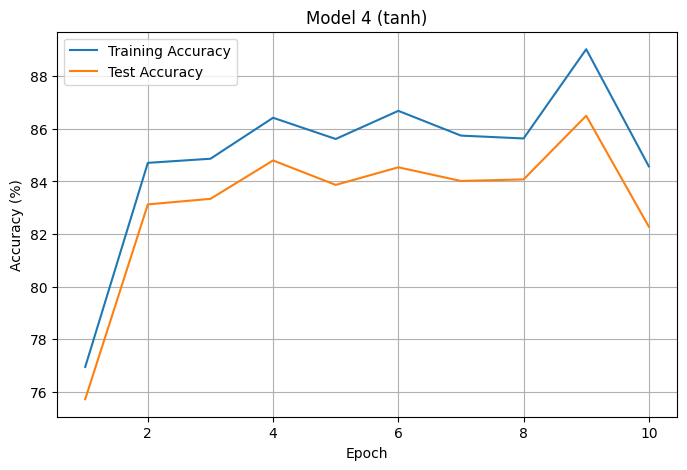

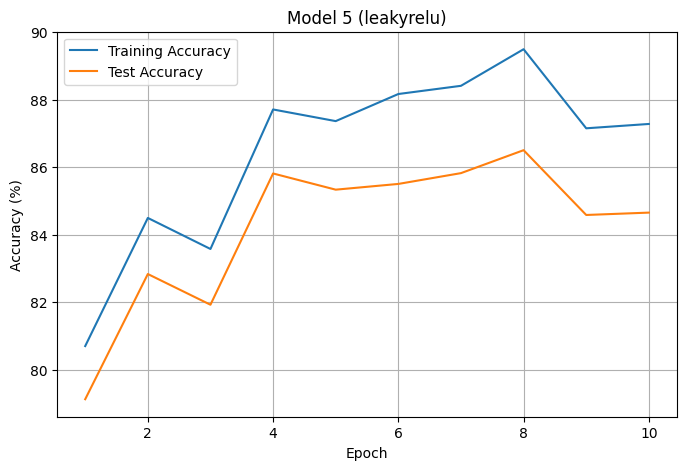

In [ ]:
plot_accuracies(train_accs_model4, test_accs_model4, 'Model 4 (tanh)')
plot_accuracies(train_accs_model5, test_accs_model5, 'Model 5 (leakyrelu)')

##3.3

L1

In [ ]:
model_l1 = MLP(784, [256,256], 10)
print("Training model_l1...")
train_accs_model_l1, test_accs_model_l1 = train_with_tracking(
    model_l1, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256,
    l1_lambda=1e-5
)

acc_model_l1 = test_accs_model_l1[-1]


Training model_l1...
Epoch 1/10  Train Acc=76.15%  Test Acc=74.98%
Epoch 2/10  Train Acc=85.71%  Test Acc=83.96%
Epoch 3/10  Train Acc=84.02%  Test Acc=82.08%
Epoch 4/10  Train Acc=87.53%  Test Acc=85.44%
Epoch 5/10  Train Acc=86.86%  Test Acc=84.99%
Epoch 6/10  Train Acc=87.82%  Test Acc=85.45%
Epoch 7/10  Train Acc=87.05%  Test Acc=84.66%
Epoch 8/10  Train Acc=86.68%  Test Acc=84.54%
Epoch 9/10  Train Acc=90.13%  Test Acc=87.13%
Epoch 10/10  Train Acc=86.53%  Test Acc=83.51%


L2


In [ ]:
model_l2 = MLP(784, [256,256], 10)
print("Training model_l2...")
train_accs_model_l2, test_accs_model_l2 = train_with_tracking(
    model_l2, X_train, y_train, X_test, y_test, lr=0.1, epochs=10, batch_size=256,
    l2_lambda=1e-4
)

acc_model_l2 = test_accs_model_l2[-1]


Training model_l2...
Epoch 1/10  Train Acc=76.04%  Test Acc=74.79%
Epoch 2/10  Train Acc=85.83%  Test Acc=84.07%
Epoch 3/10  Train Acc=83.88%  Test Acc=82.02%
Epoch 4/10  Train Acc=87.61%  Test Acc=85.60%
Epoch 5/10  Train Acc=86.94%  Test Acc=84.96%
Epoch 6/10  Train Acc=87.68%  Test Acc=85.37%
Epoch 7/10  Train Acc=87.16%  Test Acc=84.78%
Epoch 8/10  Train Acc=86.39%  Test Acc=84.37%
Epoch 9/10  Train Acc=90.19%  Test Acc=87.08%
Epoch 10/10  Train Acc=86.50%  Test Acc=83.40%


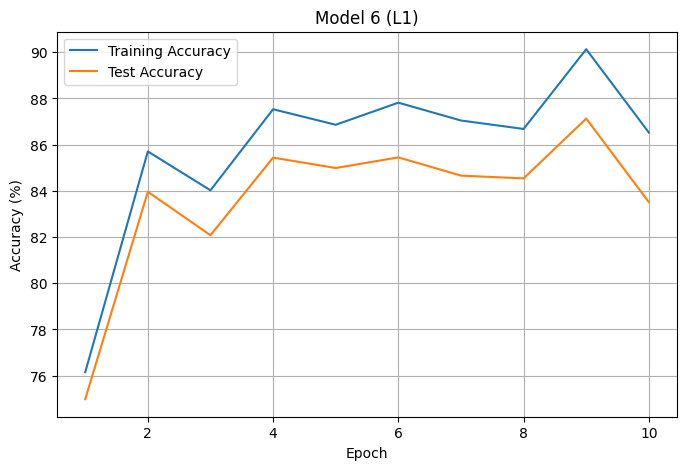

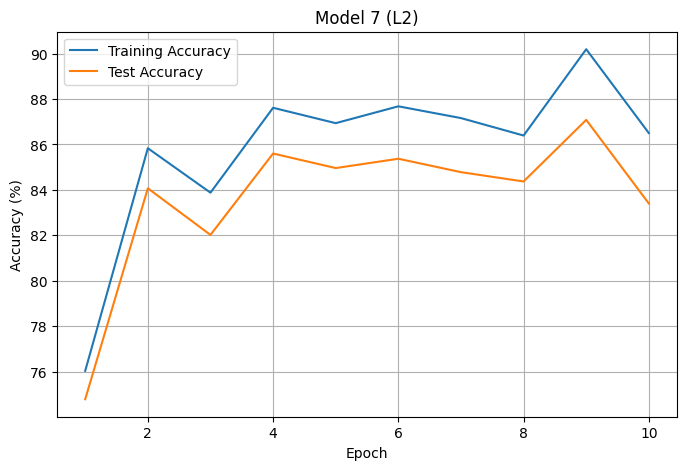

In [ ]:
plot_accuracies(train_accs_model_l1, test_accs_model_l1, 'Model 6 (L1)')
plot_accuracies(train_accs_model_l2, test_accs_model_l2, 'Model 7 (L2)')

##3.4 Unnormalized

In [ ]:
X_train_unnorm, y_train_unnorm = tensor_to_numpy(train_loader_no_norm)
X_test_unnorm,  y_test_unnorm  = tensor_to_numpy(test_loader_no_norm)
model_unnorm = MLP(784, [256,256], 10, activation="relu")
print("Training model_unnorm...")
train_accs_model_unnorm, test_accs_model_unnorm = train_with_tracking(
    model_unnorm, X_train_unnorm, y_train_unnorm, X_test_unnorm, y_test_unnorm, lr=0.01, epochs=10, batch_size=256
)

acc_model_unnorm = test_accs_model_unnorm[-1]


Training model_unnorm...
Epoch 1/10  Train Acc=69.73%  Test Acc=68.53%
Epoch 2/10  Train Acc=74.60%  Test Acc=73.18%
Epoch 3/10  Train Acc=77.41%  Test Acc=76.17%
Epoch 4/10  Train Acc=80.00%  Test Acc=78.42%
Epoch 5/10  Train Acc=81.16%  Test Acc=79.46%
Epoch 6/10  Train Acc=81.39%  Test Acc=79.78%
Epoch 7/10  Train Acc=81.68%  Test Acc=80.28%
Epoch 8/10  Train Acc=82.70%  Test Acc=80.91%
Epoch 9/10  Train Acc=83.20%  Test Acc=81.63%
Epoch 10/10  Train Acc=83.44%  Test Acc=81.74%


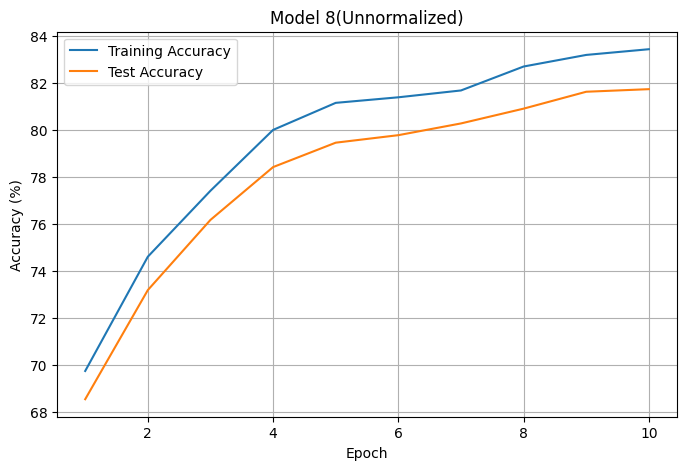

In [ ]:
plot_accuracies(train_accs_model_unnorm, test_accs_model_unnorm, 'Model 8(Unnormalized)')

##3.5 Data augmentation

In [ ]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))   # flatten for MLP
])

train_dataset_aug = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=False,
    transform=aug_transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=False,
    transform=train_transform
)

train_subset_aug, val_subset_aug = random_split(
    train_dataset_aug,
    [train_size, val_size]
)
train_loader_aug = DataLoader(train_subset_aug, batch_size=256, shuffle=True)
val_loader_aug   = DataLoader(val_subset_aug, batch_size=256, shuffle=False)
test_loader_no_norm_here      = DataLoader(test_dataset, batch_size=256, shuffle=False)

X_train_aug, y_train_aug = tensor_to_numpy(train_loader_aug)
X_val_aug,   y_val_aug   = tensor_to_numpy(val_loader_aug)

# NOTE: Need to use the *original* X_test and y_test for evaluation, or re-load it if it was overwritten
# Re-loading the original test set (normalized) just in case previous cells overwrote it with unnormalized
X_test_orig, y_test_orig = tensor_to_numpy(DataLoader(datasets.FashionMNIST(root='./data', train=False, download=False, transform=train_transform), batch_size=batch_size, shuffle=False))

model_aug = MLP(
    input_dim=784,
    hidden_layers=[256,256],
    num_classes=10,
    activation="relu"
)

print("Training model_aug...")
train_accs_model_aug, test_accs_model_aug = train_with_tracking(
    model_aug,
    X_train_aug,
    y_train_aug,
    X_test_orig, # Evaluate on the standard normalized test set
    y_test_orig, # Evaluate on the standard normalized test set
    lr=0.01,
    epochs=10,
    batch_size=64
)
acc_aug = test_accs_model_aug[-1]
print("Test accuracy WITH augmentation:", acc_aug)


Training model_aug...
Epoch 1/10  Train Acc=69.96%  Test Acc=71.62%
Epoch 2/10  Train Acc=73.09%  Test Acc=74.52%
Epoch 3/10  Train Acc=72.73%  Test Acc=75.49%
Epoch 4/10  Train Acc=75.31%  Test Acc=76.77%
Epoch 5/10  Train Acc=76.62%  Test Acc=77.58%
Epoch 6/10  Train Acc=74.95%  Test Acc=76.19%
Epoch 7/10  Train Acc=76.47%  Test Acc=77.14%
Epoch 8/10  Train Acc=79.30%  Test Acc=79.42%
Epoch 9/10  Train Acc=79.09%  Test Acc=79.58%
Epoch 10/10  Train Acc=77.96%  Test Acc=78.72%
Test accuracy WITH augmentation: 0.7872


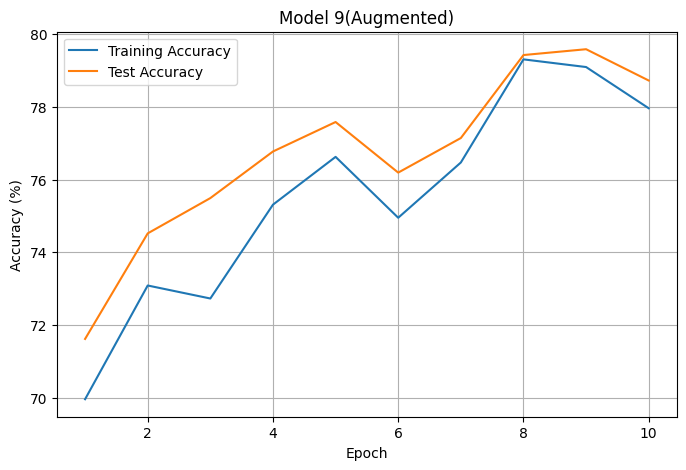

In [ ]:
plot_accuracies(train_accs_model_aug, test_accs_model_aug, 'Model 9(Augmented)' )

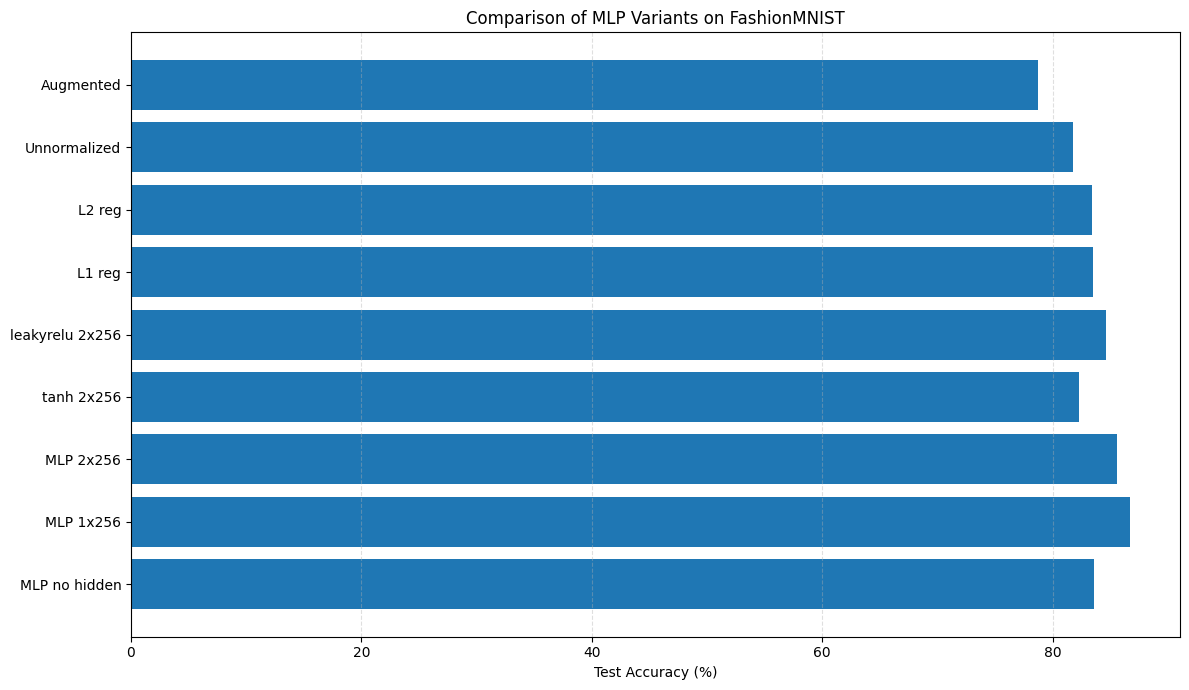

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


accs = {
    "MLP no hidden": acc_model1,
    "MLP 1x256": acc_model2,
    "MLP 2x256": acc_model3,
    "tanh 2x256": acc_model4,
    "leakyrelu 2x256": acc_model5,
    "L1 reg": acc_model_l1,
    "L2 reg": acc_model_l2,
    "Unnormalized": acc_model_unnorm,
    "Augmented": acc_aug
}

labels = list(accs.keys())
values = [accs[k] * 100 for k in labels]

plt.figure(figsize=(12,7))
plt.barh(labels, values)
plt.xlabel("Test Accuracy (%)")
plt.title("Comparison of MLP Variants on FashionMNIST")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


##3.6 CNN

In [ ]:
# Install necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [ ]:
# Transform: ToTensor + Normalize (not flatten!)
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=cnn_transform)
test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=cnn_transform)

# Split train into train/val
train_size = int(0.83 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

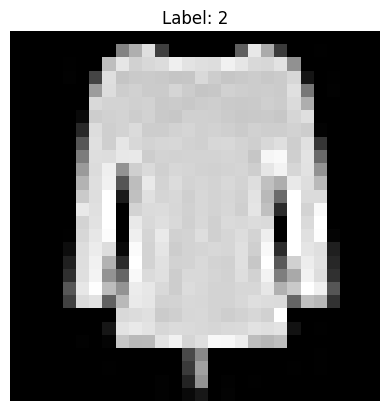

In [ ]:
images, labels = next(iter(train_loader))

plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # conv1: 1 → 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28×28 → 32×28×28

        # conv2: 32 → 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28×28 → 64×28×28

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)  # 28×28 → 14×14

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

Running on: cuda


In [ ]:
def train_and_evaluate_cnn(model, train_loader, criterion, optimizer, epochs, device):
    train_accs_list = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Only compute training accuracy
        train_acc = evaluate(model, train_loader)
        train_accs_list.append(train_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

    return train_accs_list


In [ ]:
from tqdm import tqdm

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

learning_rates = [0.001, 0.005, 0.01, 0.1]
results_lr = {}
epochs_cnn = 2   # fast

for lr in learning_rates:
    print(f"\n--- Training CNN with learning rate: {lr} ---")

    model_lr = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_lr.parameters(), lr=lr)

    train_accs = train_and_evaluate_cnn(
        model_lr, train_loader, criterion, optimizer, epochs_cnn, device
    )
    results_lr[lr] = train_accs

    print(f"Final Training Accuracy for lr={lr}: {train_accs[-1]*100:.2f}%")





--- Training CNN with learning rate: 0.001 ---


Epoch 1/2 | Loss: 297.1040 | Train Acc: 0.9156


Epoch 2/2 | Loss: 178.2142 | Train Acc: 0.9406
Final Training Accuracy for lr=0.001: 94.06%

--- Training CNN with learning rate: 0.005 ---


Epoch 1/2 | Loss: 338.4756 | Train Acc: 0.8985


Epoch 2/2 | Loss: 204.5669 | Train Acc: 0.9215
Final Training Accuracy for lr=0.005: 92.15%

--- Training CNN with learning rate: 0.01 ---


Epoch 1/2 | Loss: 364.3952 | Train Acc: 0.8830


Epoch 2/2 | Loss: 240.4771 | Train Acc: 0.8831
Final Training Accuracy for lr=0.01: 88.31%

--- Training CNN with learning rate: 0.1 ---


Epoch 1/2 | Loss: 16570.3108 | Train Acc: 0.0996


Epoch 2/2 | Loss: 1800.6968 | Train Acc: 0.1002
Final Training Accuracy for lr=0.1: 10.02%


In [ ]:
batch_sizes = [32, 64, 128, 256]
results_bs = {}
epochs_cnn = 2   # fast
best_lr = 0.001  # chosen from previous experiment

for bs in batch_sizes:
    print(f"\n--- Training CNN with batch size: {bs} ---")

    # IMPORTANT: rebuild dataloader for this batch size
    train_loader_bs = DataLoader(train_subset, batch_size=bs, shuffle=True)

    model_bs = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_bs.parameters(), lr=best_lr)

    train_accs = train_and_evaluate_cnn(
        model_bs, train_loader_bs, criterion, optimizer, epochs_cnn, device
    )
    results_bs[bs] = train_accs

    print(f"Final Training Accuracy for batch_size={bs}: {train_accs[-1]*100:.2f}%")





--- Training CNN with batch size: 32 ---


Epoch 1/2 | Loss: 553.2888 | Train Acc: 0.9247


Epoch 2/2 | Loss: 332.9096 | Train Acc: 0.9368
Final Training Accuracy for batch_size=32: 93.68%

--- Training CNN with batch size: 64 ---


Epoch 1/2 | Loss: 293.6952 | Train Acc: 0.9073


Epoch 2/2 | Loss: 176.7089 | Train Acc: 0.9359
Final Training Accuracy for batch_size=64: 93.59%

--- Training CNN with batch size: 128 ---


Epoch 1/2 | Loss: 159.7642 | Train Acc: 0.8813


Epoch 2/2 | Loss: 97.0013 | Train Acc: 0.9278
Final Training Accuracy for batch_size=128: 92.78%

--- Training CNN with batch size: 256 ---


Epoch 1/2 | Loss: 90.1407 | Train Acc: 0.8929


Epoch 2/2 | Loss: 54.8233 | Train Acc: 0.9138
Final Training Accuracy for batch_size=256: 91.38%


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
from tqdm import tqdm

train_accs_cnn = []
test_accs_cnn = []

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate training accuracy for the epoch
    train_acc = evaluate(model, train_loader)
    train_accs_cnn.append(train_acc)

    # Calculate test accuracy for the epoch
    test_acc = evaluate(model, test_loader)
    test_accs_cnn.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:10<00:00, 144.50it/s]


Epoch 1/10 | Loss: 557.7037 | Train Acc: 0.9182 | Test Acc: 0.8997


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:10<00:00, 147.91it/s]


Epoch 2/10 | Loss: 324.8801 | Train Acc: 0.9485 | Test Acc: 0.9160


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:10<00:00, 149.20it/s]


Epoch 3/10 | Loss: 231.8871 | Train Acc: 0.9687 | Test Acc: 0.9227


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:13<00:00, 119.62it/s]


Epoch 4/10 | Loss: 158.3839 | Train Acc: 0.9801 | Test Acc: 0.9220


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:14<00:00, 109.47it/s]


Epoch 5/10 | Loss: 99.7356 | Train Acc: 0.9856 | Test Acc: 0.9174


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 130.20it/s]


Epoch 6/10 | Loss: 71.6280 | Train Acc: 0.9935 | Test Acc: 0.9228


100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:17<00:00, 90.75it/s]


Epoch 7/10 | Loss: 45.8634 | Train Acc: 0.9958 | Test Acc: 0.9233


100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:17<00:00, 90.88it/s]


Epoch 8/10 | Loss: 37.1873 | Train Acc: 0.9903 | Test Acc: 0.9136


100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:20<00:00, 77.36it/s]


Epoch 9/10 | Loss: 36.5009 | Train Acc: 0.9947 | Test Acc: 0.9212


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:14<00:00, 111.17it/s]


Epoch 10/10 | Loss: 23.5741 | Train Acc: 0.9979 | Test Acc: 0.9216


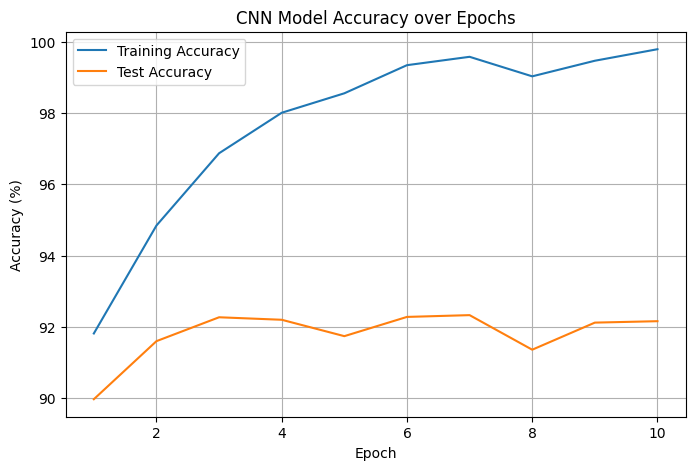

In [ ]:
plot_accuracies(train_accs_cnn, test_accs_cnn, 'CNN Model Accuracy over Epochs')



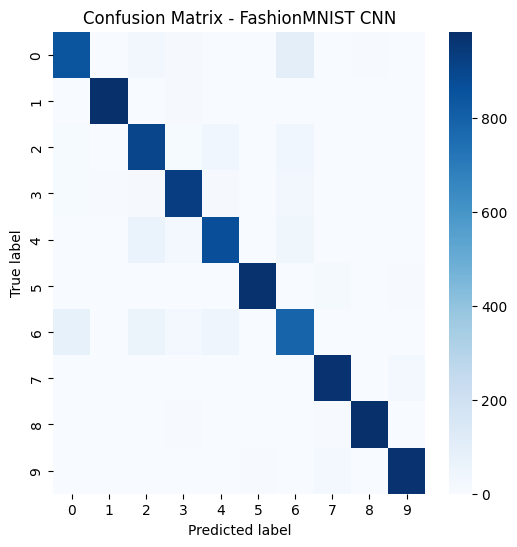

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix - FashionMNIST CNN")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

##3.7 CNN with data augmentation

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# === Data Augmentation from Q5 ===
train_transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset_aug = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=train_transform_aug
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=False,
    transform=test_transform
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
from tqdm import tqdm

train_accs_cnn = []
test_accs_cnn = []

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate training accuracy for the epoch
    train_acc = evaluate(model, train_loader)
    train_accs_cnn.append(train_acc)

    # Calculate test accuracy for the epoch
    test_acc = evaluate(model, test_loader)
    test_accs_cnn.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:16<00:00, 97.17it/s]


Epoch 1/10 | Loss: 554.9251 | Train Acc: 0.9177 | Test Acc: 0.8965


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:12<00:00, 126.38it/s]


Epoch 2/10 | Loss: 317.4261 | Train Acc: 0.9518 | Test Acc: 0.9136


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 130.73it/s]


Epoch 3/10 | Loss: 218.0795 | Train Acc: 0.9688 | Test Acc: 0.9229


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:10<00:00, 152.82it/s]


Epoch 4/10 | Loss: 143.2928 | Train Acc: 0.9752 | Test Acc: 0.9138


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 136.12it/s]


Epoch 5/10 | Loss: 87.7609 | Train Acc: 0.9905 | Test Acc: 0.9195


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:13<00:00, 116.10it/s]


Epoch 6/10 | Loss: 56.9028 | Train Acc: 0.9938 | Test Acc: 0.9254


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:13<00:00, 119.60it/s]


Epoch 7/10 | Loss: 45.3105 | Train Acc: 0.9924 | Test Acc: 0.9162


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 131.73it/s]


Epoch 8/10 | Loss: 34.7834 | Train Acc: 0.9957 | Test Acc: 0.9219


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 132.50it/s]


Epoch 9/10 | Loss: 33.8480 | Train Acc: 0.9940 | Test Acc: 0.9172


100%|█████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:11<00:00, 132.51it/s]


Epoch 10/10 | Loss: 20.9835 | Train Acc: 0.9939 | Test Acc: 0.9128


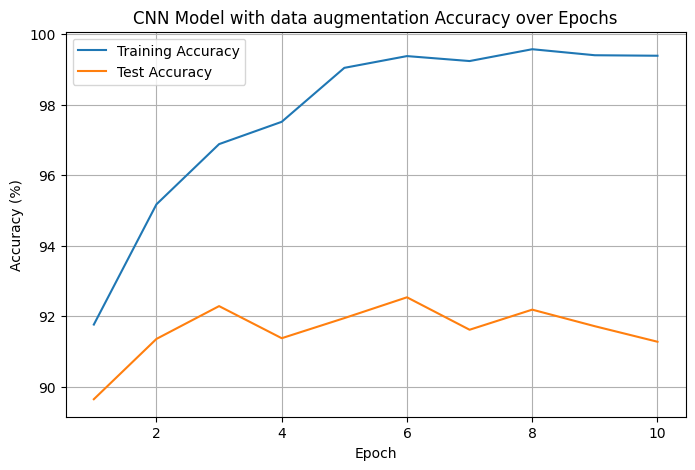

In [ ]:
plot_accuracies(train_accs_cnn, test_accs_cnn, 'CNN Model with data augmentation Accuracy over Epochs')

##3.8

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Q5 Data Augmentation Pipeline
# -----------------------------
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.Resize((224, 224)),               # ResNet requires 224x224
    transforms.Grayscale(num_output_channels=3), # Convert 1 channel → 3 channels
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# -----------------------------
# Load FashionMNIST with augmentation
# -----------------------------
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=train_transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -----------------------------
# Load Pretrained ResNet18
# -----------------------------
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze ALL convolutional layers
for param in resnet.parameters():
    param.requires_grad = False

# Remove original fully connected layer
# Original: resnet.fc = nn.Linear(512, 1000)
# Replace with our own FC layers
resnet.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
)

resnet = resnet.to(device)

# Only train our new FC layers
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 2
for epoch in range(num_epochs):
    resnet.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {total_loss:.3f}  Train Acc: {train_acc:.2f}%")

# -----------------------------
# Evaluate on Test Set
# -----------------------------
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"\nTest Accuracy (Transfer Learning): {test_acc:.2f}%")

Using device: cuda


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.88it/s]


Epoch 1/2  Loss: 635.472  Train Acc: 75.27%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.86it/s]


Epoch 2/2  Loss: 505.138  Train Acc: 80.50%

Test Accuracy (Transfer Learning): 82.93%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load dataset
train_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=train_transform)
test_dataset  = datasets.FashionMNIST("./data", train=False, download=True, transform=test_transform)

def get_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


In [ ]:
def build_resnet(fc_head):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # freeze backbone
    for param in model.parameters():
        param.requires_grad = False

    # replace final FC
    model.fc = fc_head
    return model.to(device)

In [ ]:
def train_epochs(model, train_loader, optimizer, criterion, epochs=2):
    train_acc_list = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        total_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        train_acc_list.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss={total_loss:.3f} | Train Acc={acc:.4f}")

    return train_acc_list

In [ ]:
heads = {
    "1-layer": nn.Sequential(
        nn.Linear(512, 10)
    ),
    "2-layer": nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ),
    "3-layer": nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 10)
    ),
}

criterion = nn.CrossEntropyLoss()

In [ ]:
train_loader, test_loader = get_loaders(batch_size=64)

print("\n===== Testing Different FC Heads (2 Epochs) =====")
fc_results = {}

for name, head in heads.items():
    print(f"\n--- Testing FC Head: {name} ---")
    model = build_resnet(head)
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

    train_accs = train_epochs(model, train_loader, optimizer, criterion, epochs=2)
    fc_results[name] = train_accs[-1]

print("\nFC Head Comparison:")
for k, v in fc_results.items():
    print(f"{k} final train acc = {v*100:.2f}%")

best_head_name = max(fc_results, key=fc_results.get)
best_head = heads[best_head_name]
print(f"\nBEST FC STRUCTURE = {best_head_name}")


===== Testing Different FC Heads (2 Epochs) =====

--- Testing FC Head: 1-layer ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.87it/s]


Epoch 1/2 | Loss=658.932 | Train Acc=0.7680


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.91it/s]


Epoch 2/2 | Loss=488.024 | Train Acc=0.8135

--- Testing FC Head: 2-layer ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:43<00:00,  9.07it/s]


Epoch 1/2 | Loss=575.382 | Train Acc=0.7821


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:46<00:00,  8.80it/s]


Epoch 2/2 | Loss=468.238 | Train Acc=0.8179

--- Testing FC Head: 3-layer ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:47<00:00,  8.75it/s]


Epoch 1/2 | Loss=631.752 | Train Acc=0.7557


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:47<00:00,  8.69it/s]

Epoch 2/2 | Loss=503.418 | Train Acc=0.8050

FC Head Comparison:
1-layer final train acc = 81.35%
2-layer final train acc = 81.79%
3-layer final train acc = 80.50%

BEST FC STRUCTURE = 2-layer


In [ ]:
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3]
lr_results = {}

print("\n===== Testing Different Learning Rates =====")
for lr in learning_rates:
    print(f"\n--- LR = {lr} ---")
    model = build_resnet(best_head)
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    train_accs = train_epochs(model, train_loader, optimizer, criterion, epochs=2)
    lr_results[lr] = train_accs[-1]

print("\nLearning Rate Results:")
for lr, acc in lr_results.items():
    print(f"LR {lr}: {acc*100:.2f}%")

best_lr = max(lr_results, key=lr_results.get)
print(f"\nBEST LR = {best_lr}")


===== Testing Different Learning Rates =====

--- LR = 0.0001 ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:46<00:00,  8.78it/s]


Epoch 1/2 | Loss=406.881 | Train Acc=0.8413


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:44<00:00,  9.00it/s]


Epoch 2/2 | Loss=397.445 | Train Acc=0.8437

--- LR = 0.0005 ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:46<00:00,  8.82it/s]


Epoch 1/2 | Loss=408.572 | Train Acc=0.8405


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.85it/s]


Epoch 2/2 | Loss=397.575 | Train Acc=0.8437

--- LR = 0.001 ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:49<00:00,  8.55it/s]


Epoch 1/2 | Loss=410.014 | Train Acc=0.8399


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:44<00:00,  9.00it/s]


Epoch 2/2 | Loss=395.665 | Train Acc=0.8432

--- LR = 0.005 ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:44<00:00,  9.00it/s]


Epoch 1/2 | Loss=511.238 | Train Acc=0.8018


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:44<00:00,  9.01it/s]

Epoch 2/2 | Loss=468.631 | Train Acc=0.8170

Learning Rate Results:
LR 0.0001: 84.37%
LR 0.0005: 84.37%
LR 0.001: 84.32%
LR 0.005: 81.70%

BEST LR = 0.0001


In [ ]:
batch_sizes = [32, 64, 128, 256]
bs_results = {}

print("\n===== Testing Different Batch Sizes =====")
for bs in batch_sizes:
    print(f"\n--- Batch Size = {bs} ---")
    train_loader_bs, _ = get_loaders(bs)

    model = build_resnet(best_head)
    optimizer = optim.Adam(model.fc.parameters(), lr=best_lr)

    train_accs = train_epochs(model, train_loader_bs, optimizer, criterion, epochs=2)
    bs_results[bs] = train_accs[-1]

print("\nBatch Size Results:")
for bs, acc in bs_results.items():
    print(f"Batch Size {bs}: {acc*100:.2f}%")

best_bs = max(bs_results, key=bs_results.get)
print(f"\nBEST BATCH SIZE = {best_bs}")



===== Testing Different Batch Sizes =====

--- Batch Size = 32 ---


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:49<00:00, 17.16it/s]


Epoch 1/2 | Loss=825.603 | Train Acc=0.8381


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:51<00:00, 16.89it/s]


Epoch 2/2 | Loss=805.208 | Train Acc=0.8419

--- Batch Size = 64 ---


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.87it/s]


Epoch 1/2 | Loss=382.329 | Train Acc=0.8487


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.87it/s]


Epoch 2/2 | Loss=373.378 | Train Acc=0.8525

--- Batch Size = 128 ---


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:43<00:00,  4.54it/s]


Epoch 1/2 | Loss=184.456 | Train Acc=0.8545


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:41<00:00,  4.64it/s]


Epoch 2/2 | Loss=182.688 | Train Acc=0.8557

--- Batch Size = 256 ---


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:42<00:00,  2.30it/s]


Epoch 1/2 | Loss=89.411 | Train Acc=0.8594


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.30it/s]

Epoch 2/2 | Loss=88.996 | Train Acc=0.8604

Batch Size Results:
Batch Size 32: 84.19%
Batch Size 64: 85.25%
Batch Size 128: 85.57%
Batch Size 256: 86.04%

BEST BATCH SIZE = 256



===== FINAL 10-EPOCH TRAINING =====


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.31it/s]


Epoch 1/10 | Train Acc=0.8600 | Test Acc=0.8585


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:40<00:00,  2.33it/s]


Epoch 2/10 | Train Acc=0.8599 | Test Acc=0.8577


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:42<00:00,  2.30it/s]


Epoch 3/10 | Train Acc=0.8596 | Test Acc=0.8579


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.32it/s]


Epoch 4/10 | Train Acc=0.8606 | Test Acc=0.8579


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.31it/s]


Epoch 5/10 | Train Acc=0.8622 | Test Acc=0.8574


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:42<00:00,  2.30it/s]


Epoch 6/10 | Train Acc=0.8607 | Test Acc=0.8582


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.32it/s]


Epoch 7/10 | Train Acc=0.8618 | Test Acc=0.8591


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:40<00:00,  2.35it/s]


Epoch 8/10 | Train Acc=0.8630 | Test Acc=0.8583


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:41<00:00,  2.31it/s]


Epoch 9/10 | Train Acc=0.8643 | Test Acc=0.8589


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [01:39<00:00,  2.35it/s]


Epoch 10/10 | Train Acc=0.8632 | Test Acc=0.8583


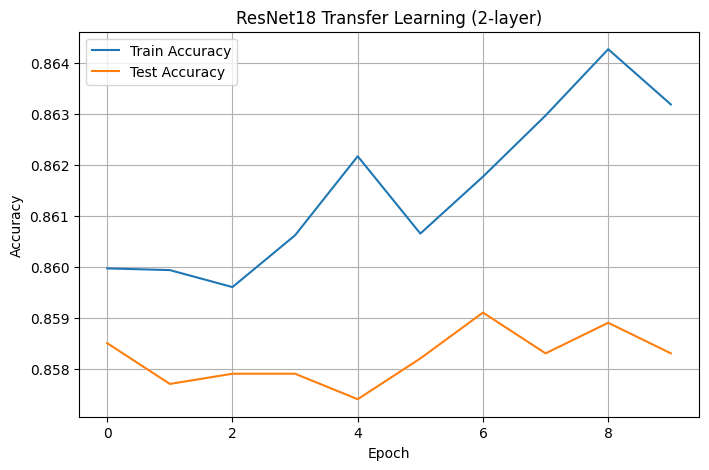

In [ ]:
train_loader, test_loader = get_loaders(best_bs)
model = build_resnet(best_head)
optimizer = optim.Adam(model.fc.parameters(), lr=best_lr)

train_acc_list = []
test_acc_list = []

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return correct / total

print("\n===== FINAL 10-EPOCH TRAINING =====")
for epoch in range(10):
    model.train()
    correct, total = 0, 0
    total_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    test_acc = evaluate(model, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/10 | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")

# Plot results
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.title(f"ResNet18 Transfer Learning ({best_head_name})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Experiments

##Investigate width of hidden layer for MLP

In [ ]:
widths = [32, 64, 128, 256, 512]
results_width = {}
epochs_width = 2
lr_width = 0.1
batch_size_width = 64

In [ ]:
print("\n=== Investigating Effect of Width on MLP Performance ===")

for w in widths:
    print(f"\n--- Training MLP with hidden width = {w} ---")

    model_w = MLP(
        input_dim=784,
        hidden_layers=[w],
        num_classes=10,
        activation="relu"
    )

    model_w.fit(
        X_train, y_train,
        lr=lr_width,
        epochs=epochs_width,
        batch_size=batch_size_width,
        verbose=False
    )

    # compute test accuracy
    test_acc = MLP.evaluate_acc(y_test, model_w.predict(X_test))
    results_width[w] = test_acc

    print(f"Hidden width = {w}, Test Accuracy = {test_acc*100:.2f}%")


=== Investigating Effect of Width on MLP Performance ===

--- Training MLP with hidden width = 32 ---
Hidden width = 32, Test Accuracy = 77.77%

--- Training MLP with hidden width = 64 ---
Hidden width = 64, Test Accuracy = 77.35%

--- Training MLP with hidden width = 128 ---
Hidden width = 128, Test Accuracy = 77.15%

--- Training MLP with hidden width = 256 ---
Hidden width = 256, Test Accuracy = 84.43%

--- Training MLP with hidden width = 512 ---
Hidden width = 512, Test Accuracy = 83.58%


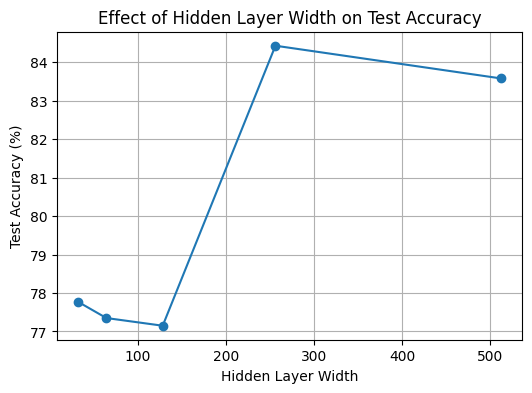

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(widths, [results_width[w]*100 for w in widths], marker='o')
plt.title("Effect of Hidden Layer Width on Test Accuracy")
plt.xlabel("Hidden Layer Width")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

## Investigate the effect of the CNN's convolutional layer hyperparameters (number of filters, kernel size, stride,padding, ...) on its test accuracy

Using: cuda

Testing config: {'num_filters1': 16, 'num_filters2': 32, 'kernel_size': 3}


⮕ Test Accuracy = 89.85%

Testing config: {'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 3}


⮕ Test Accuracy = 90.04%

Testing config: {'num_filters1': 64, 'num_filters2': 128, 'kernel_size': 3}


⮕ Test Accuracy = 90.61%

Testing config: {'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 5, 'padding': 2}


⮕ Test Accuracy = 90.12%

Testing config: {'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 3, 'stride': 2, 'padding': 1}


⮕ Test Accuracy = 83.45%

===== FINAL RESULTS =====
{'num_filters1': 16, 'num_filters2': 32, 'kernel_size': 3}             -> 89.85%
{'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 3}             -> 90.04%
{'num_filters1': 64, 'num_filters2': 128, 'kernel_size': 3}            -> 90.61%
{'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 5, 'padding': 2} -> 90.12%
{'num_filters1': 32, 'num_filters2': 64, 'kernel_size': 3, 'stride': 2, 'padding': 1} -> 83.45%


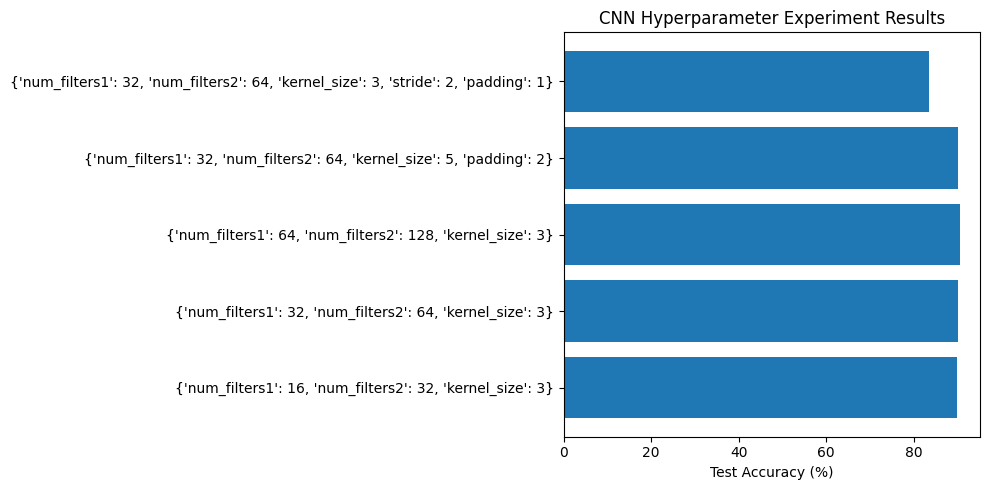

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_cnn = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=cnn_transform
)
test_dataset_cnn = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=cnn_transform
)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)


def build_cnn(num_filters1=32, num_filters2=64, kernel_size=3, stride=1, padding=1):

    class CNN(nn.Module):
        def __init__(self):
            super().__init__()

            self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=num_filters1,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )

            self.conv2 = nn.Conv2d(
                in_channels=num_filters1,
                out_channels=num_filters2,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )

            self.pool = nn.MaxPool2d(2, 2)

            # determine flattened size automatically
            dummy = torch.zeros((1, 1, 28, 28))
            dummy = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy)))))
            flatten_dim = dummy.numel()

            self.fc1 = nn.Linear(flatten_dim, 256)
            self.fc2 = nn.Linear(256, 10)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            return self.fc2(x)

    return CNN()


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()


def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return correct / total



configs = [
    {"num_filters1": 16, "num_filters2": 32, "kernel_size": 3},
    {"num_filters1": 32, "num_filters2": 64, "kernel_size": 3},
    {"num_filters1": 64, "num_filters2": 128, "kernel_size": 3},

    {"num_filters1": 32, "num_filters2": 64, "kernel_size": 5, "padding": 2},

    {"num_filters1": 32, "num_filters2": 64, "kernel_size": 3, "stride": 2, "padding": 1},
]

results = {}


criterion = nn.CrossEntropyLoss()

for cfg in configs:
    print("\nTesting config:", cfg)

    model = build_cnn(**cfg).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # quick 1 epoch
    train_one_epoch(model, train_loader_cnn, optimizer, criterion, device)

    test_acc = evaluate(model, test_loader_cnn, device)
    results[str(cfg)] = test_acc

    print(f" Test Accuracy = {test_acc * 100:.2f}%")


print("\n===== FINAL RESULTS =====")
for k, v in results.items():
    print(f"{k:70s} -> {v*100:.2f}%")


plt.figure(figsize=(10, 5))
plt.barh(list(results.keys()), [v*100 for v in results.values()])
plt.xlabel("Test Accuracy (%)")
plt.title("CNN Hyperparameter Experiment Results")
plt.tight_layout()
plt.show()


## Investigate the effect of different data augmentaion level on MLP and CNN

In [ ]:
aug_light = transforms.Compose([
    transforms.RandomRotation(3),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])
aug_medium = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])
aug_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])


In [ ]:
augmentations = {
    "light": aug_light,
    "medium": aug_medium,
    "strong": aug_strong
}

aug_results = {}

print("\n===== Training MLP with 3 levels of augmentation =====\n")

for name, aug_t in augmentations.items():
    print(f"\n=== Augmentation: {name.upper()} ===")

    # Load augmented train set
    train_dataset_aug = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=False,
        transform=aug_t
    )

    train_subset_aug, val_subset_aug = random_split(
        train_dataset_aug,
        [train_size, val_size]
    )

    train_loader_aug = DataLoader(train_subset_aug, batch_size=256, shuffle=True)

    # Convert to numpy for MLP
    X_train_aug, y_train_aug = tensor_to_numpy(train_loader_aug)

    model_aug = MLP(
        input_dim=784,
        hidden_layers=[256, 256],
        num_classes=10,
        activation="relu"
    )

    print(f"Training model_aug ({name})...")
    train_accs, test_accs = train_with_tracking(
        model_aug,
        X_train_aug, y_train_aug,
        X_test_orig, y_test_orig,   # use original normalized test set
        lr=0.01,
        epochs=10,
        batch_size=64
    )

    final_acc = test_accs[-1]
    aug_results[name] = final_acc

    print(f"Final Test Accuracy ({name}): {final_acc*100:.2f}%")



===== Training MLP with 3 levels of augmentation =====


=== Augmentation: LIGHT ===
Training model_aug (light)...
Epoch 1/10  Train Acc=81.31%  Test Acc=79.91%
Epoch 2/10  Train Acc=82.79%  Test Acc=81.48%
Epoch 3/10  Train Acc=83.43%  Test Acc=81.88%
Epoch 4/10  Train Acc=85.57%  Test Acc=83.62%
Epoch 5/10  Train Acc=83.36%  Test Acc=82.01%
Epoch 6/10  Train Acc=85.13%  Test Acc=83.80%
Epoch 7/10  Train Acc=87.26%  Test Acc=85.46%
Epoch 8/10  Train Acc=87.76%  Test Acc=85.54%
Epoch 9/10  Train Acc=88.28%  Test Acc=86.10%
Epoch 10/10  Train Acc=88.21%  Test Acc=86.27%
Final Test Accuracy (light): 86.27%

=== Augmentation: MEDIUM ===
Training model_aug (medium)...
Epoch 1/10  Train Acc=69.96%  Test Acc=72.54%
Epoch 2/10  Train Acc=72.19%  Test Acc=74.18%
Epoch 3/10  Train Acc=74.61%  Test Acc=76.04%
Epoch 4/10  Train Acc=77.47%  Test Acc=78.94%
Epoch 5/10  Train Acc=77.19%  Test Acc=78.40%
Epoch 6/10  Train Acc=74.47%  Test Acc=75.21%
Epoch 7/10  Train Acc=79.30%  Test Acc=79.74%
Epoc

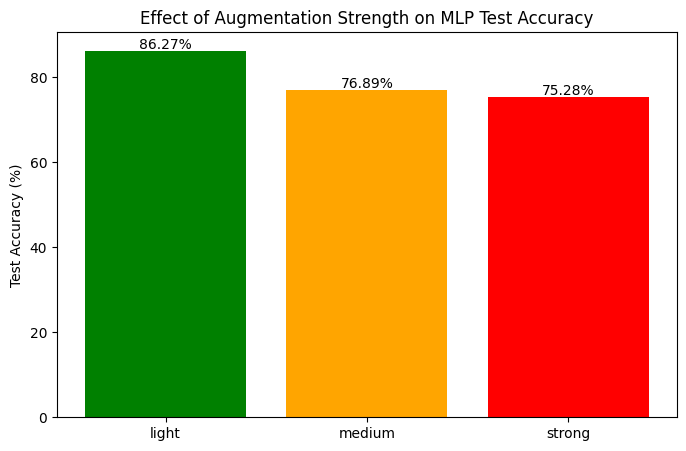

In [ ]:
import matplotlib.pyplot as plt

names = list(aug_results.keys())
accs  = [aug_results[k] * 100 for k in names]

plt.figure(figsize=(8,5))
plt.bar(names, accs, color=["green","orange","red"])
plt.ylabel("Test Accuracy (%)")
plt.title("Effect of Augmentation Strength on MLP Test Accuracy")

for i, acc in enumerate(accs):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center')

plt.show()
